# Uczenie maszynowa  
## Lista 1: Klasyfikacja k-nn

**Autor**: Patryk Rygiel (250080)  
**GitHub**: https://github.com/PatRyg99/ML-PWR-2022

In [19]:
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedKFold, RepeatedStratifiedKFold

### Utility functions

In [20]:
def custom_distance(dist):
    """Custom distance function"""
    return 1 / np.log(dist + 1.1)

def normalize(x):
    """Feature-wise normalization"""
    return (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))

def standardize(x):
    """Feature-wise standarization"""
    return (x - x.mean(axis=0)) / x.std(axis=0)

In [21]:
def predict_and_plot(model: KNeighborsClassifier, X_test: pd.DataFrame, y_test: pd.DataFrame):
    """
    Run inference on the given model and plot confusion matrix
    with confusion matrix-based metrics.
    """
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test.squeeze())
    plt.show()

def eval_knn(
        data: pd.DataFrame, 
        k: int = 5, 
        weights: str = "uniform", 
        metric: str = "minkowski", 
        cv: str = 5, 
        preprocess: callable = lambda x: x,
        stratify: bool = False,
        repeats: int = 1
    ):
    """
    Evaluates KNN for given parameters
    """
    if weights == "custom":
        weights = custom_distance

    # Split data and preprocess
    X, y = data.drop("class", axis=1), data["class"]
    X = preprocess(X)

    # Choose folding mode
    if stratify:
        kfold = RepeatedStratifiedKFold(n_splits=cv, n_repeats=repeats)
    else:
        kfold = RepeatedKFold(n_splits=cv, n_repeats=repeats)

    model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    cv_scores = cross_val_score(model, X, np.ravel(y), scoring='f1_weighted', cv=kfold)
    
    return cv_scores


def benchmark_cross_validation_preprocessors(data: pd.DataFrame, cvs: List[int], stratify: bool = False, repeats: int = 1):
    """
    Benchmark cross validation for all preprocessing modes
    """
    main_fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    main_fig.suptitle("Boxplots of F1-score for different values of folds in cross-validation and different preprocessing techniques", fontsize=16)
    
    columns = ["Folds", "F1-score (weighted)", "Stratify"]
    preprocessors = {
        "no-preprocessing": lambda x: x,
        "normalization": normalize,
        "standarization": standardize
    }

    for i, (ax, (name, preprocess)) in enumerate(zip(axes, preprocessors.items())):
        cv_tuples = []
        
        for stratify in [True, False]:
            cv_scores = {cv: eval_knn(data, cv=cv, preprocess=preprocess, stratify=stratify, repeats=repeats) for cv in cvs}
            cv_tuples += [(cv, score, stratify) for cv, scores in cv_scores.items() for score in scores]

        df = pd.DataFrame(cv_tuples, columns=columns)
        sns.boxplot(x="Folds", y="F1-score (weighted)", data=df, hue="Stratify", ax=ax)

        ax.grid(axis='y')
        ax.set_axisbelow(True)
        ax.set_title(name)
        
        if i == 0:
            ax.set_ylabel("F1-score (weighted)")
        else:
            ax.set_ylabel(None)

    plt.tight_layout()
    plt.show()


def knn_grid_search(
    data: pd.DataFrame, 
    metrics: List[str],
    weights: List[int], 
    k: int, 
    cv: int, 
    preprocess: callable = lambda x: x,
    stratify: bool = False,
    repeats: int = 1
):
    """
    Plots grid search for metrics and weights and plots series of boxplots
    """
    assert len(metrics) == len(weights), "Number of metrics and weights should be equal"

    main_fig, axes = plt.subplots(2, len(metrics), figsize=(20, 12), sharey=True, sharex=True)
    main_fig.suptitle("Boxplots of F1-score (weighted)", fontsize=20)

    columns = ["Neighbours", "F1-score (weighted)", "Metric", "Weight"]
    cv_tuples = []

    # Collect results
    for weight in weights:
        for metric in metrics:
            cv_scores = {ki: eval_knn(data, ki, weight, metric, cv, preprocess=preprocess, stratify=stratify, repeats=repeats) for ki in range(1, k + 1)}
            cv_tuples += [(k, score, metric, weight) for k, scores in cv_scores.items() for score in scores]

    # Cast to dataframe
    df = pd.DataFrame(cv_tuples, columns=columns)

    # Plot metric comparison for different weights
    for i, weight in enumerate(weights):
        ax = axes[0, i]

        sns.boxplot(x="Neighbours", y="F1-score (weighted)", data=df[df["Weight"] == weight], hue="Metric", ax=ax)
        
        ax.grid(axis='y')
        ax.set_axisbelow(True)
        ax.set_title(f"Weight: {weight}", fontsize=16)
        ax.set_xlabel(None)

        if i != 0:
            ax.set_ylabel(None)

    # Plot weights comparison for different metrics
    for i, metric in enumerate(metrics):
        ax = axes[1, i]

        sns.boxplot(x="Neighbours", y="F1-score (weighted)", data=df[df["Metric"] == metric], hue="Weight", ax=ax)

        ax.grid(axis='y')
        ax.set_axisbelow(True)
        ax.set_title(f"Metric: {metric}", fontsize=16)
        
        if i != 0:
            ax.set_ylabel(None)

    plt.tight_layout()
    plt.show()

# IRIS

## 1. Ładowanie zbioru danych

In [22]:
dir = "../Lista 0/zbiory/iris.data"
iris_data = pd.read_csv(dir, names=["sepal-length", "sepal-width", "petal-length", "petal-width", "class"])

iris_data.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

Dzielimy zbiór na losowe podzbiory podanej wielkości.

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         5
Iris-versicolor       0.87      1.00      0.93        13
 Iris-virginica       1.00      0.83      0.91        12

       accuracy                           0.93        30
      macro avg       0.96      0.94      0.95        30
   weighted avg       0.94      0.93      0.93        30



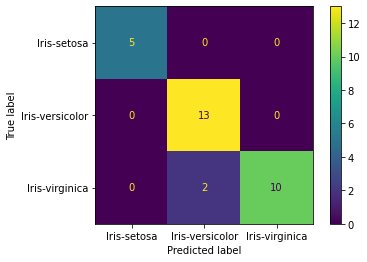

In [23]:
train_data, test_data = train_test_split(iris_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

2.1.2. Stratified split

Najpierw dzielimy zbiór na podzbiory według przynależności do klasy, a następnie dla każdego podzbioru dokonujemy losowego podziału na zbiór treningowy i testowy według zadanych wielkości. W taki sposób zapewniamy, że rozkład klas w zbiorze treningowym jak i testowym jest taki sam - klasy są równie dobrze reprezentowane.

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



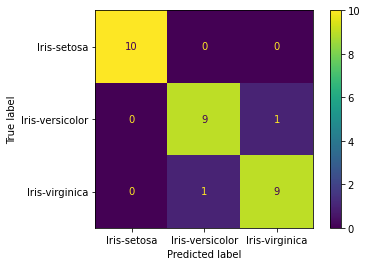

In [24]:
train_data, test_data = train_test_split(iris_data, train_size=0.8, stratify=iris_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

## 3. Trenowanie z walidacją krzyżową

Walidacja krzyżowa wielkości `k` polega na podziale zbioru danych na `k` równych (w kontekście ilości próbek - można też ze stratyfikacją) rozłącznych podzbiorów. Następnie tworzone jest `k` zbiorów danych, dla których wcześniej wyodrębnione podzbiory stanowią podzbiory walidacyjne, natomiast ich dopełnienie jest zbiorem treningowym. W taki sposób jakośc modelu jest lepiej ewaluowana, gdyż nie pomijamy żadnych danych jakie posiadamy w kontekście ewaluacji - arbitralny podział może nie brać poprawnie pod uwagę potencjalnych outlierów. 

W tej sekcji będziemy benchmarkować jakość modelu dla parametrów:
* ilość splitów: 2, 5, 10
* rodzaj preprocessingu: brak, normalizacja, standaryzacja
* stratyfikacja oraz jej brak

Wzory:
$$ \text{Normalize}(x) = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}} $$
$$ \text{Standardize}(x) = \frac{x - \mu_x}{\sigma_x} $$

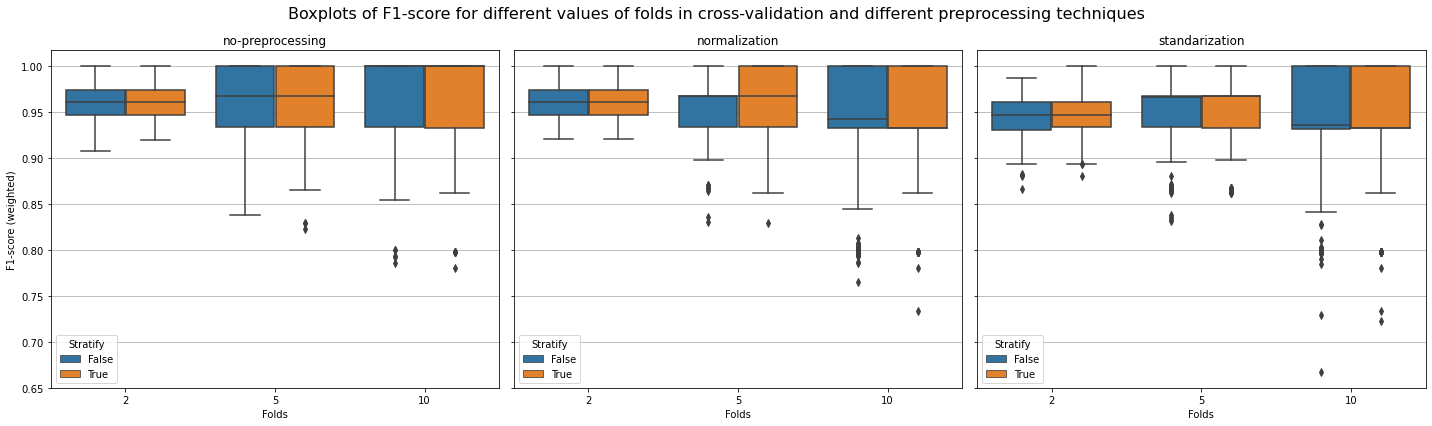

In [25]:
benchmark_cross_validation_preprocessors(iris_data, cvs=[2, 5, 10], repeats=100)

Ilość foldów w walidacji krzyżowej wpływa na to na jakiej ilości danych trenowane są modele - im więcej splitów tym mniejsze pojedyczne zbiory walidacyjne, zatem większe zbiory treningowe. Różnice w wynikach dla różnych ilości foldów są znikome.

Średnie wyniki (mediana, średnia) dla wyników ze stratyfikacją i bez są prawie takie same, natomiaast wyniki bez stratyfikacji mają wyższe odchylenie standardowe. Jest to spowodowane zupełną losowością doboru splitów co sprawia, że niektóre podzbiory walidacyjne są dużo łatwiejsze od innych. Stratyfikacja gwarantuje bardziej stabline wyniki oraz lepszą ewaluację modelu.

Patrząc na metody pre-processing'u nie jest widoczna duża różnica pomiędzy modelami, powodem takiego zachowania jest prawdopodobnie fakt, że feature'y w zbiorze Iris są default'owo w bardzo podobnej skali.

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* stratyfikacji
* walidacji krzyżowej z 5 foldami
* braku preprocessing'u

Klasyfikator k-nn używa paremetru *metric* (metryka) do obliczania odległości pomiędzy próbkami - na podstawie tej odległości jest wybierana zadania ilość sąsiadów na podstawie, której predykowana jest klasa nowej próbki. Jako metryki będziemy badać:  
* *euclidean* (L2):   
    $d(p, q) = \sqrt{\sum_{i=1}^n (q_i - p_i)^2}$  
    
* *manhattan* (L1):   
    $d(p, q) = \sum_{i=1}^n |q_i - p_i|$

* *chebyshev*:
    $d(p, q) = \max_{i} |q_i - p_i|$


Mając już wyznaczonych $k$ najbliższych sąsiadów na podstawie zadanej metryki odległości, dokonujemy głosowania na tym zbiorze. Dla próbki dla każdego z jej sąsiadów znamy jego klasę - klasa nowej próbki jest estymowana poprzez wybraną formę głosowania. Jako formy głosowania będziemy badać:
* *uniform*: każdy sąsiad jest tak samo istotny (niezależnie od odległości) - praktycznie wybierana jest najczęściej występująca klasa wśród sąsiadów

* *distance*: waga sąsiadów jest ważona przy użyciu odwrotności odległości

* *custom*: waga sąsiadów jest ważona przy użyciu funkcji: $w(d_x) = \frac{1}{ln(d_x + 1.1)}$, gdzie $d_x$ to odległość punktu $x$ od nowej próbki, policzona przy użyciu metryki odległości

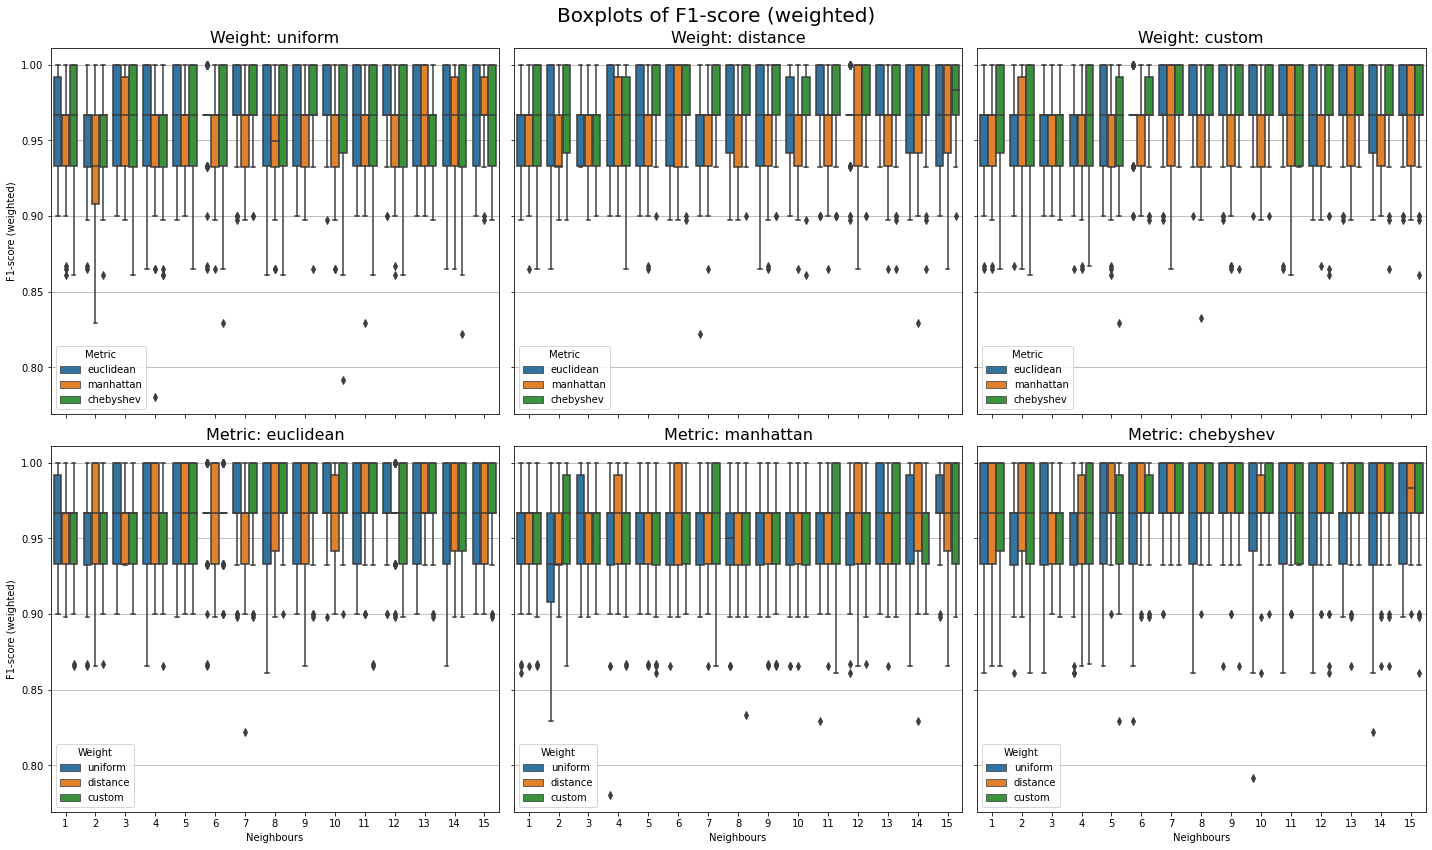

In [26]:
knn_grid_search(
    iris_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=5, 
    stratify=True,
    repeats=10
)

Dla wszystkich kombinacji parametrów klasyfikator dla zbioru Iris osiąga bardzo dobre rezultaty (mediana F1-score (weighted) $> 92.5$). Najlepsze i najbardziej stabilne wyniki możemu zaobserwować dla metryki *chebysev* oraz metody głosowania *custom* dla ilości sąsiadów 6-10.

# GLASS

## 1. Ładowanie zbioru danych

In [27]:
dir = "../Lista 0/zbiory/glass.data"
glass_data = pd.read_csv(dir, names=["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "class"]).reset_index()
glass_data = glass_data.drop("index", axis=1)

# With labels confusion matrix is very clotted and unreadable
# class_map = {
#     1: "building_windows_float_processed", 
#     2: "building_windows_non_float_processed",
#     3: "vehicle_windows_float_processed",
#     5: "containers",
#     6: "tableware",
#     7: "headlamps"
# }
# glass_data = glass_data.replace({"class": class_map})

glass_data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

              precision    recall  f1-score   support

         1.0       0.48      0.91      0.62        11
         2.0       0.77      0.59      0.67        17
         3.0       0.00      0.00      0.00         5
         5.0       0.50      0.67      0.57         3
         6.0       0.00      0.00      0.00         2
         7.0       1.00      0.60      0.75         5

    accuracy                           0.58        43
   macro avg       0.46      0.46      0.44        43
weighted avg       0.58      0.58      0.55        43



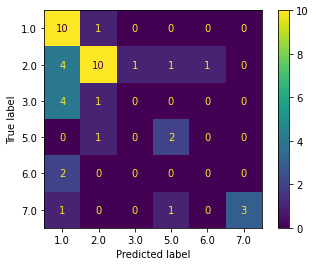

In [28]:
train_data, test_data = train_test_split(glass_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

2.1.2. Stratified split

              precision    recall  f1-score   support

         1.0       0.60      0.86      0.71        14
         2.0       0.89      0.53      0.67        15
         3.0       0.33      0.33      0.33         3
         5.0       0.60      1.00      0.75         3
         6.0       0.00      0.00      0.00         2
         7.0       0.83      0.83      0.83         6

    accuracy                           0.67        43
   macro avg       0.54      0.59      0.55        43
weighted avg       0.69      0.67      0.65        43



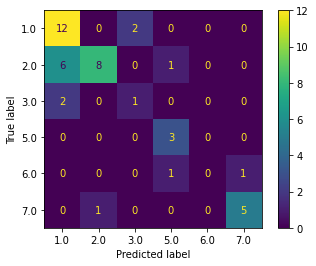

In [29]:
train_data, test_data = train_test_split(glass_data, train_size=0.8, stratify=glass_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

## 3. Trenowanie z walidacją krzyżową

W tej sekcji będziemy benchmarkować jakość modelu dla parametrów:
* ilość splitów: 2, 5, 9 (nie 10, bo jedna z klas w zbiorze glass ma tylko 9 reprezentantów)
* rodzaj preprocessingu: brak, normalizacja, standaryzacja
* stratyfikacja oraz jej brak

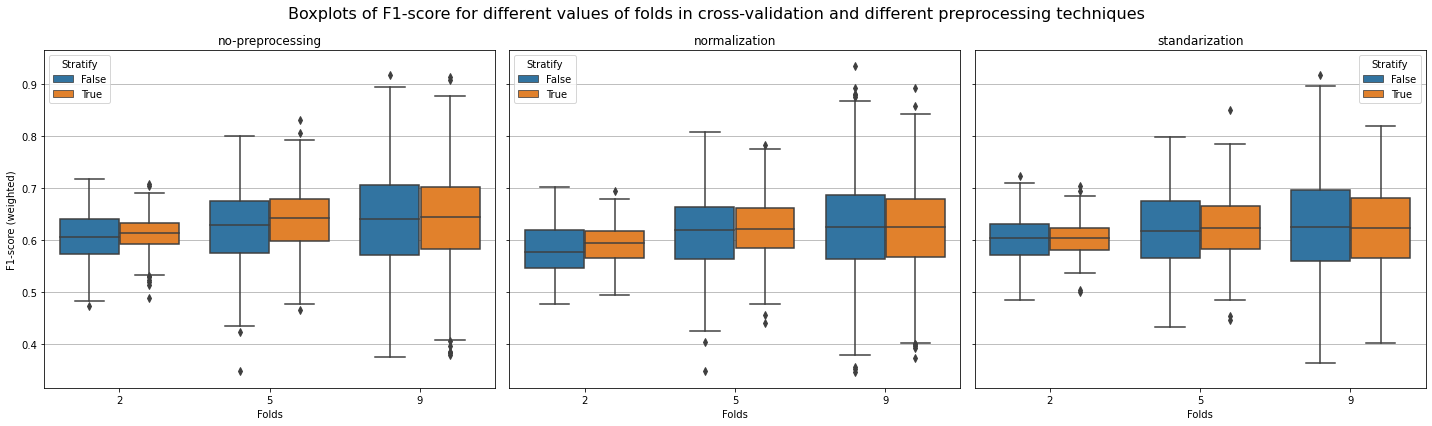

In [30]:
benchmark_cross_validation_preprocessors(glass_data, cvs=[2, 5, 9], repeats=100)

Podobnie jak dla zbioru iris, obserwujemy, że wyniki ze stratyfikacją mają mniejsze odchylenie standardowe. Ponownie większa ilość splitów poprawia wyniki klasyfikatora oraz rodzaj pre-processing'u nie ma większego wpływu na wyniki modelu.

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* stratyfikacji
* walidacji krzyżowej z 9 foldami
* standaryzacji

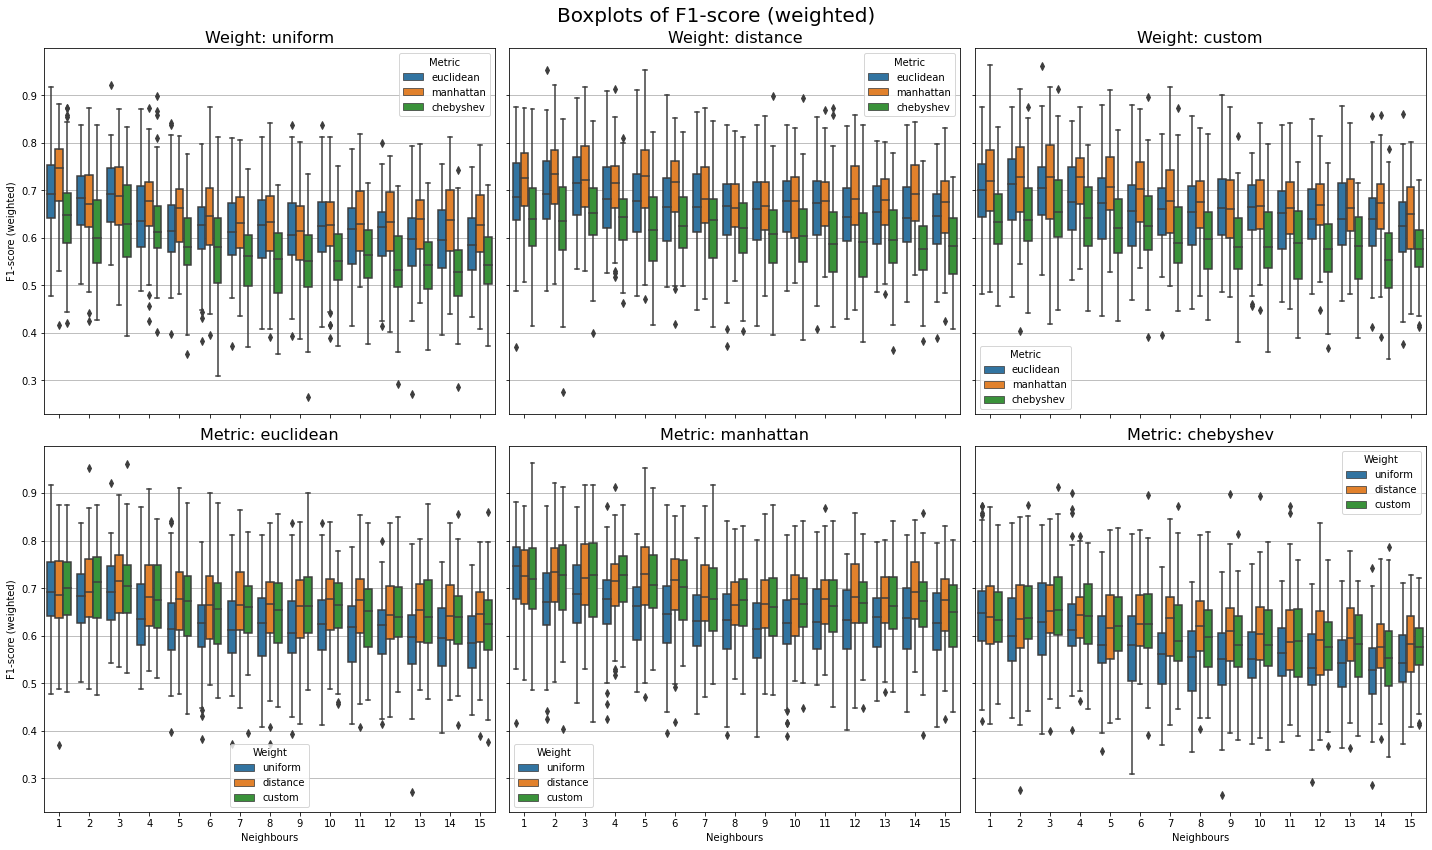

In [31]:
knn_grid_search(
    glass_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=9, 
    preprocess=standardize,
    stratify=True,
    repeats=10
)

Analizując wyniki dla różnych kombinacji parametrów zauważamy, że tym razem metryka *chebysev* daje najsłabsze rezultaty, natomiast *manhattan* zdaje się być najlepszym wyborem. Jeśli chodzi od rodzaj głosowania, ewidentnie wersja *uniform* jest najsłabsza, a dla metryki *manhattan* głosowanie po odległości *distance* oraz *custom* daje najlepsze rezultaty dla ilości sąsiadów 1-5.

# WINE

## 1. Ładowanie zbioru danych

In [32]:
dir = "../Lista 0/zbiory/wine.data"
wine_data = pd.read_csv(
    dir, 
    names=[
        "class", "Alcohol", "Malic acid", "Ash", "Alcanity of ash", "Magnesium", 
        "Total phenols", "Flavanoids", "Nonflavanoid phenosis", "Proanthocyanins",
        "Color intensity", "Hue", "OD280/OD315 of diluted wine", "Proline"
    ]
)

wine_data = wine_data[list(wine_data.columns.values)[1:] + ["class"]]

wine_data.head()

,Alcohol,Malic acid,Ash,Alcanity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenosis,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wine,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


## 2. Trenowanie z domyślnymi parametrami

Klasyfikator KNN jako domyślnych wartości używa:
* ilość sąsiadów: $2$
* metryka: Minkowski z $p = 2$, czyli Euklides 
* głosowanie (weight): większościowe (uniform)

### 2.1 Podział zbioru

2.1.1. Random split

              precision    recall  f1-score   support

         1.0       0.62      0.73      0.67        11
         2.0       0.62      0.67      0.64        12
         3.0       0.50      0.38      0.43        13

    accuracy                           0.58        36
   macro avg       0.58      0.59      0.58        36
weighted avg       0.57      0.58      0.57        36



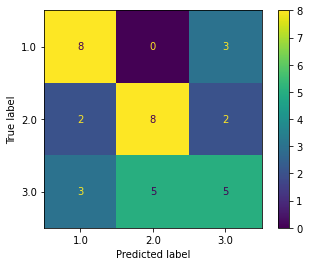

In [33]:
train_data, test_data = train_test_split(wine_data, train_size=0.8)

X_train, y_train = np.split(train_data, [-1], axis=1)
X_test, y_test = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train, y_train.squeeze())

predict_and_plot(model, X_test, y_test)

2.1.2. Stratified split

              precision    recall  f1-score   support

         1.0       0.79      0.92      0.85        12
         2.0       0.71      0.71      0.71        14
         3.0       0.75      0.60      0.67        10

    accuracy                           0.75        36
   macro avg       0.75      0.74      0.74        36
weighted avg       0.75      0.75      0.75        36



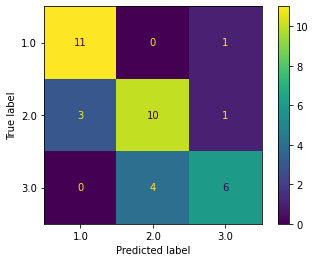

In [34]:
train_data, test_data = train_test_split(wine_data, train_size=0.8, stratify=wine_data["class"])

X_train_str, y_train_str = np.split(train_data, [-1], axis=1)
X_test_str, y_test_str = np.split(test_data, [-1], axis=1)

model = KNeighborsClassifier()
model.fit(X_train_str, y_train_str.squeeze())

predict_and_plot(model, X_test_str, y_test_str)

## 3. Trenowanie z walidacją krzyżową

Testujemy trzy różne ilości splitów: 2, 5, 10.

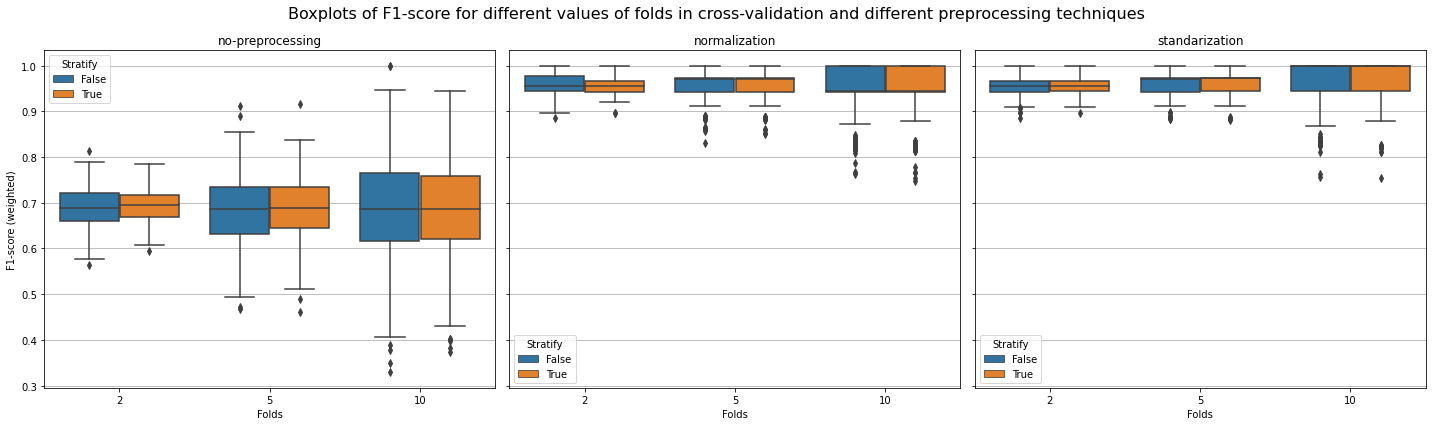

In [35]:
benchmark_cross_validation_preprocessors(wine_data, cvs=[2, 5, 10], repeats=100)

W porównaniu do poprzednio analizowanych zbiorów, zbiór wine ewdentnie wymaga normalizacji bądź standaryzacji cech - wyniki poprawiane są o ok. 30 pkt procentowych. Jest to spowodowane dużą rozbieżnością dziedzin cech - mamy do czynienia z cechami o wartościach z zakresu tysięcy (np. proline) jak i dziesiętnych części po przecinku (np. Nonflavanoid phenosis). 

Jeśli chodzi o pozostałe parametry: stratify i ilość foldów, spotrzeżenia poczynione dla poprzednich zbiorów są odzwierciedlane także i w tym przypadku.

## 4. Porównanie jakości modelu dla różnych wartości parametrów

Na podstawie powyższych eksperymentów będziemy używać:
* stratyfikacji
* walidacji krzyżowej z 5 foldami
* normalizacja

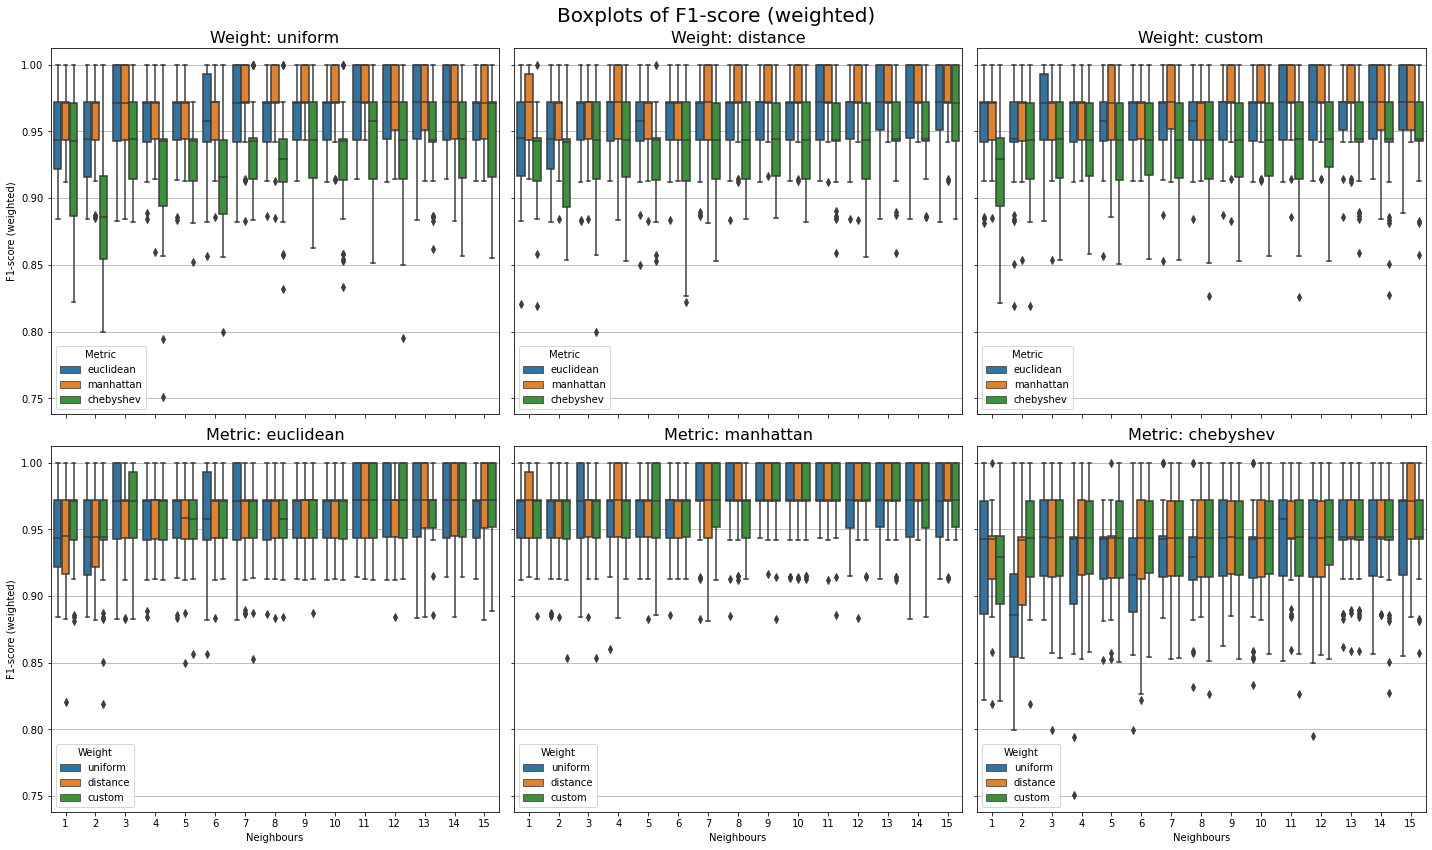

In [36]:
knn_grid_search(
    wine_data, 
    metrics=["euclidean", "manhattan", "chebyshev"], 
    weights=["uniform", "distance", "custom"], 
    k=15, 
    cv=5, 
    preprocess=normalize,
    stratify=True,
    repeats=10
)

Analizując wyniki dla różnych kombinacji parametrów klasyfikatora, możemy zauważyć, że metryka *chebyshev* daje najgorsze rezultaty, a najlepsze są osiągane dla metryki *mahattan*. Dla tej metryki głosowanie *distance* daje najlepsze wyniki, które są osiagane dla wyzszych wartości sąsiadów 9-14.

# Pytania

### 1. Czy powinno używać się procedury mieszania danych (tj. *shuffle*)?

Odp: Dla modeli używających batchy, mieszanie danych jest zalecane, aby ograniczyć overfitting - nie wchodzą do modelu co epokę te same dane. W przypadku k-nn mieszanie danych nie ma za bardzo zastosowania z tego względu, że dla k-nn kolejność danych nie jest istotna. Predykcja jest wykonywana na podstawie szukania przykładów treningowych o najmniejszej odległości od ewaluowanej próbki - operacja minimum jest symetryczna, daje ten sam wynik bez znaczenia na permutacje danych.

### 2. Co jest modelem klasyfikacji w tym zadaniu? Dlaczego k-nn jest typu *lazy learning*?

Odp: W tym zadaniu klasyfikacja nowej próbki jest dokonywana na podstawie szukania najbardziej podobnych do niej próbek (sąsiadów) ze zbioru treningowego. Na podstawie odległości sąsiadów oraz ich klas predykowana jest klasa nowej próbki. K-nn jest typu *lazy-learning*, gdyż nie wymaga żadnego wcześniejszego uczenia - model zapamiętuje tylko próbki jakie otrzymał w zbiorze treningowym i tylko w ramach inferencji dokonuje obliczeń. 

### 3. Ile parametrów ma klasyfikator k-nn? Które z nich są istotne dla skuteczności?

Odp: Klasyfikator k-nn ma 3 różne parametry: ilość sąsiadów, sposób głosowania oraz funkcję odległości. Wszystkie trzy parametry są istotne dla skuteczności, natomiast jak mocno, który polepsza skuteczność modelu jest zależne od zbioru danych. 

### 4. Czym się różni walidacja krzyżowa stratyfikowana od "zwykłej"?

Odp: Podział stratyfikowany polega na podzieleniu zbioru na podzbiory w taki sposób aby wszystkie klasy były równo reprezentowane w każdym z podzbiorów.

### 5. Dlaczego zwykle nie stosujemy walidacji krzyżowej *leave-one-out*?

Odp: Walidacja krzyżowa *leave-one-out* polega na wykonaniu tylu splitów w walidacji krzyżowej ile jest elementów w zbiorze danych - dla każdego splitu mamy jeden element w zbiorze walidacyjnym. Z reguły nie stosuje się takiej techniki, gdyż jest ona bardzo czaso i zasobo-żerna oraz nie oferuje z praktycznego punktu widzenia lepszej ewaluacji niż np. 2 elementy w zbiorze walidacyjnym per split.

### 6. Czy k-nn wymaga standaryzacji/normalizacji danych?

Odp: K-nn wymaga standaryzacji/normalizacjia danych ze względu na to, że model jest oparty na liczeniu odległości pomiędzy próbkami. Gdy cechy mają różne dziedziny, model będzie bardziej zbiasowany w kierunku matchowania tej konkretnej cechy co nie ma żadnego uzasadnienia z formalnego punktu widzenia - wszystkie cechy powinniśmy uważać za równe chyba, że chcemy umieścić w modelowaniu jakąś wiedzę dziedzinową a priori.

### 7. Dlaczego miara Accuracy dla zbiorów niezbalansowanych jest mniej użyteczna niż miara F-score?

Odp: Miara accuracy jest gorszym wyborem niż F-score, gdyż bada ona tylko ilość poprawnie zaklasyfikowanych próbek co sprawia, że klasy słabiej reprezentowane mają mniejszy wpływ  na wartość accuracy - poprawność klasyfikacji na klasie z większą ilością reprezentantów dominuje wartość metryki. 

### 8. Warto także zwrócić uwagę czy parzysta i nieparzysta liczba sąsiadów daje podobne wyniki? Dlaczego?

Odp: W powyżej przeprowadzonych badaniach nie zaobserwowałem znaczącej różnicy pomiędzy parzystą, a nieparzystą ilością sąsiadów. W teorii nieparzysta ilość sąsiadów powinna być lepsze, gdyż nie ma możliwości powstania przy głosowaniu *uniform* remisów pomiędzy dwoma klasami, co może się wydarzyć dla parzystej ilości.